In [111]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import attila_utils
#plt.rcParams['figure.dpi'] = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
fpath = '../../resources/QPS/5xFAD-mouse/amiloride-behavioral-data-cleaned.xlsx'
mwm = pd.read_excel(fpath, sheet_name='rawdata MWM day 1-4', header=[0,1], index_col=None)
mwm = pd.DataFrame(mwm.iloc[:, 4:].to_numpy(), columns=mwm.iloc[:, 4:].columns, index=pd.MultiIndex.from_frame(mwm.iloc[:, :4].xs('Covariates', axis=1, level=0)))
mwm = mwm.stack(level=1)
mwm = mwm.rename_axis(mwm.index.names[:-1] + ['Day'], axis=0)
mwm = pd.concat([mwm, mwm.index.to_frame()], axis=1)
mwm['Day'] = mwm.Day.str.replace('Day ', '').astype(pd.Int64Dtype())
mwm

Distance (m)  Floating %  Latency (s)  \
Cohort Group Sex IRN     Day                                            
I      A     f   12913 A Day 1     10.841028    0.532622        60.08   
                         Day 2      5.720320    7.641773        26.06   
                         Day 3      3.967948    9.397345        22.70   
                         Day 4      2.178462    6.630220        18.06   
                 12915 A Day 1      8.892240    4.043839        47.62   
...                                      ...         ...          ...   
III    C     m   13958 A Day 4      3.717858    7.993118        20.74   
                 13962 A Day 1     10.552825    1.930759        60.08   
                         Day 2      9.089775    0.798936        60.08   
                         Day 3      3.030865    7.857635        19.78   
                         Day 4      6.122248    4.698587        33.14   

                                Thigmotaxis %  Velocity (m/s) Cohort Group  \
Cohort Group Sex IRN     Day                                                 
I      A     f   12913 A Day 1      66.311600        0.180684      I     A   
                         Day 2      33.259165        0.202247      I     A   
                         Day 3      16.170368        0.166473      I     A   
                         Day 4       7.830300        0.120461      I     A   
                 12915 A Day 1      70.582225        0.182376      I     A   
...                                       ...             ...    ...   ...   
III    C     m   13958 A Day 4      32.184900        0.165693    III     C   
                 13962 A Day 1      44.906775        0.175880    III     C   
                         Day 2      18.708375        0.151496    III     C   
                         Day 3      15.243320        0.154832    III     C   
                         Day 4      25.740050        0.176833    III     C   

                               Sex      IRN  Day  
Cohort Group Sex IRN     Day                      
I      A     f   12913 A Day 1   f  12913 A    1  
                         Day 2   f  12913 A    2  
                         Day 3   f  12913 A    3  
                         Day 4   f  12913 A    4  
                 12915 A Day 1   f  12915 A    1  
...                             ..      ...  ...  
III    C     m   13958 A Day 4   m  13958 A    4  
                 13962 A Day 1   m  13962 A    1  
                         Day 2   m  13962 A    2  
                         Day 3   m  13962 A    3  
                         Day 4   m  13962 A    4  

[172 rows x 10 columns]

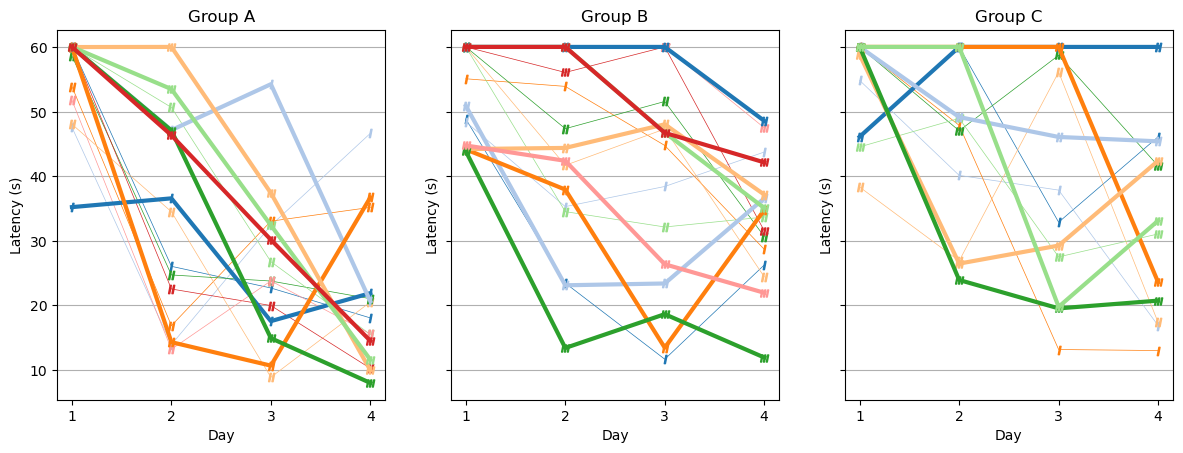

In [103]:
def data_plotter(yname='Latency (s)', mwm=mwm):
    fig, ax = plt.subplots(1, len(mwm.Group.unique()), sharey=True, figsize=(3 * 4.8, 4.8))
    for group, axi in zip(mwm.Group.unique(), ax):
        axi.set_title('Group ' + group)
        axi.set_ylabel(yname)
        axi.set_xlabel('Day')
        axi.set_xticks(range(5))
        axi.set_xticklabels(range(5))
        axi.grid(axis='y')
        df1 = mwm.xs(group, level=1)
        for sex, linewidth in zip(df1.Sex.unique(), [0.5, 3]):
            df2 = df1.xs(sex, level=1)
            for irn, color in zip(df2.IRN.unique(), plt.color_sequences['tab20'][:len(df2.IRN.unique())]):
                df3 = df2.xs(irn, level=1)
                for cohort in df3.Cohort.unique():
                    s = sex + cohort
                    y = df3[yname]
                    x = df3.Day
                    axi.plot(x, y, color=color, label=irn, marker='$' + cohort + '$', linewidth=linewidth)
                pass
            pass
        #axi.legend()
    return((fig, ax))

fig, ax = data_plotter(yname='Latency (s)')

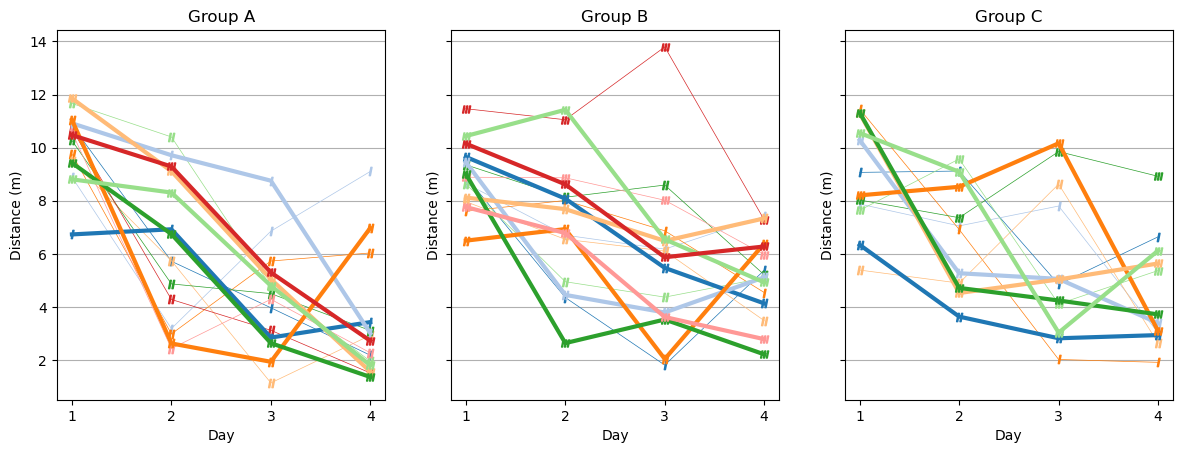

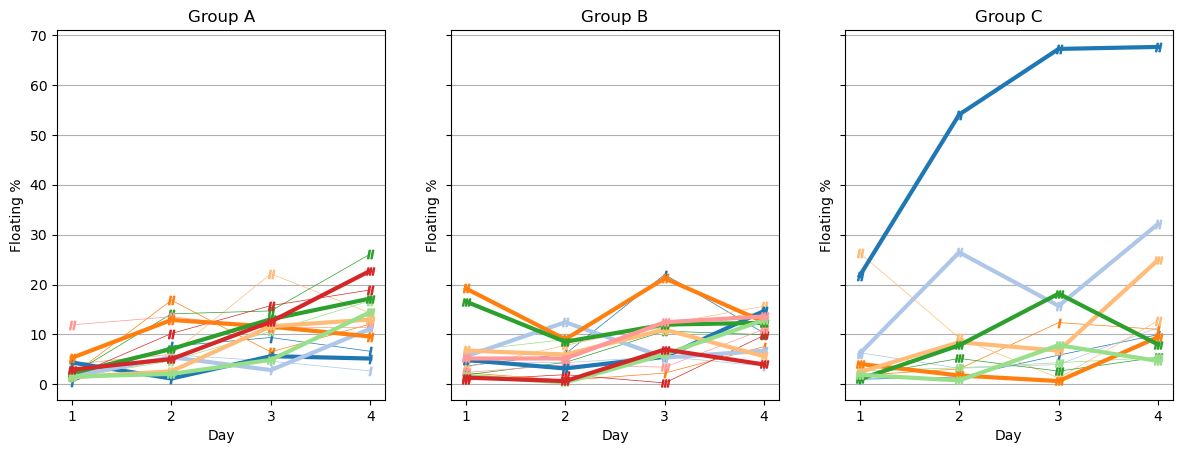

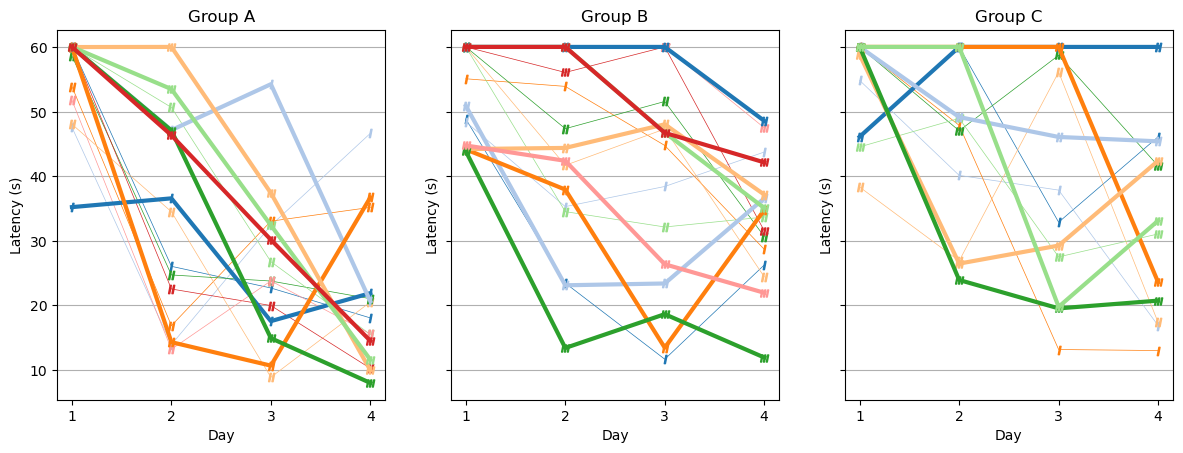

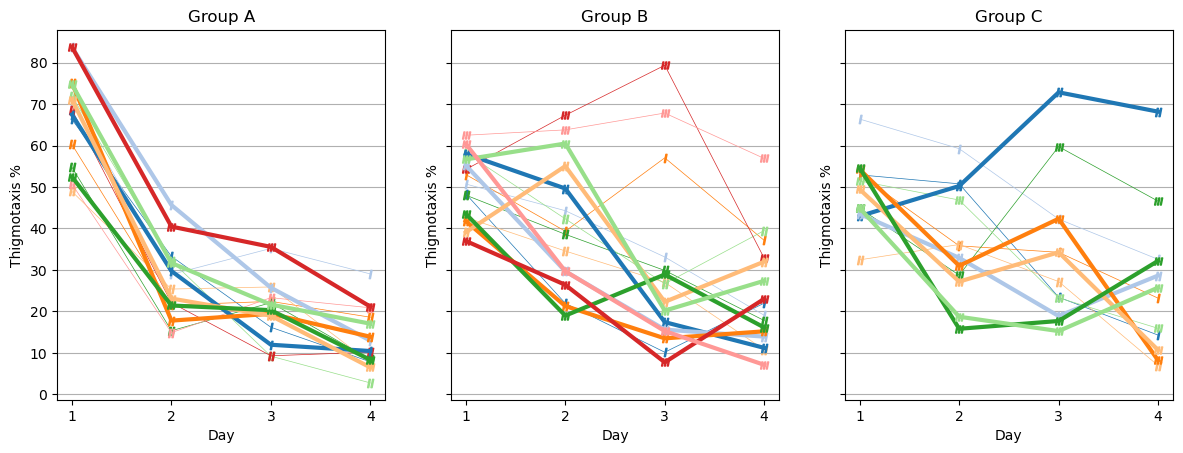

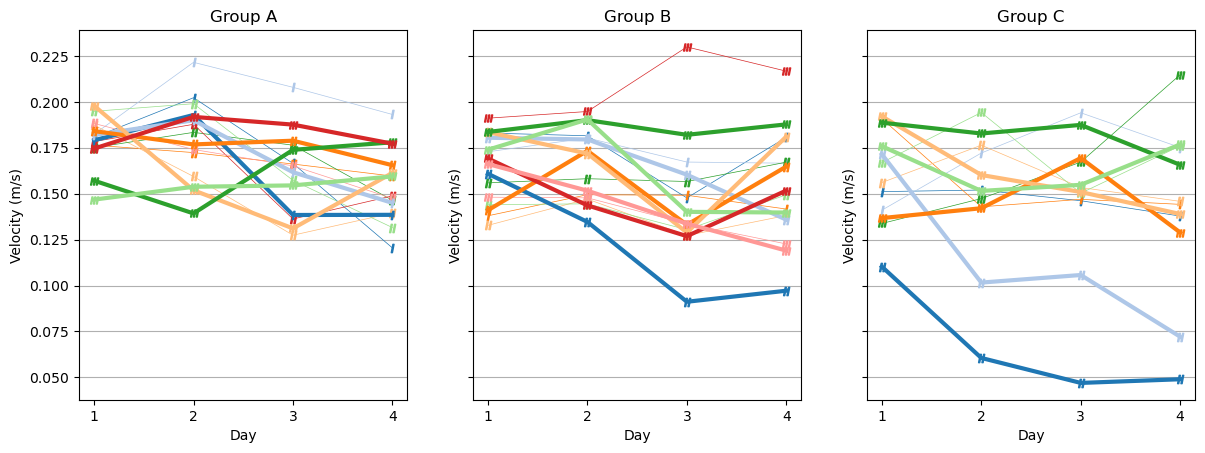

In [115]:
for yname in mwm.loc[:, :'Velocity (m/s)'].columns:
    fig, ax = data_plotter(yname=yname)
    attila_utils.savefig(fig, 'training-' + re.sub('[ ()%/]+', '-', s).strip('-'))

In [2]:
%connect_info

{
  "shell_port": 56132,
  "iopub_port": 56133,
  "stdin_port": 56134,
  "control_port": 56136,
  "hb_port": 56135,
  "ip": "127.0.0.1",
  "key": "0b00ed42-c70c920d5140ec0d9d96755d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-4f5c7f45-f524-475d-b617-f29dad04db25.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
